In [2]:
# Use the entire 20 Newsgroups dataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

# Load the full dataset
newsgroups_data = fetch_20newsgroups(subset='all')
vectorizer = TfidfVectorizer(max_features=2000)
X_A = vectorizer.fit_transform(newsgroups_data.data).toarray()
y_A = newsgroups_data.target

# Convert to tensors
X_A_tensor = torch.tensor(X_A, dtype=torch.float32)
y_A_tensor = torch.tensor(y_A, dtype=torch.long)


In [3]:
from nltk.corpus import reuters
from sklearn.preprocessing import LabelEncoder

# Load Reuters dataset
documents = reuters.fileids()
X_B = [reuters.raw(doc_id) for doc_id in documents if doc_id.startswith('training/')]
y_B = [reuters.categories(doc_id)[0] for doc_id in documents if doc_id.startswith('training/')]

# Convert labels to numerical format
label_encoder = LabelEncoder()
y_B_encoded = label_encoder.fit_transform(y_B)

# Use TF-IDF vectorization
X_B = vectorizer.transform(X_B).toarray()  # Use the same vectorizer as Domain A
X_B_tensor = torch.tensor(X_B, dtype=torch.float32)
y_B_tensor = torch.tensor(y_B_encoded, dtype=torch.long)


In [4]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
dataset_A = TextDataset(X_A_tensor, y_A_tensor)
dataset_B = TextDataset(X_B_tensor, y_B_tensor)

# Split into train, validation, and test
from torch.utils.data import random_split

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15):
    total_len = len(dataset)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    test_len = total_len - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])

train_dataset_A, val_dataset_A, test_dataset_A = split_dataset(dataset_A)
train_dataset_B, val_dataset_B, test_dataset_B = split_dataset(dataset_B)

# Create DataLoaders
train_loader_A = DataLoader(train_dataset_A, batch_size=32, shuffle=True)
val_loader_A = DataLoader(val_dataset_A, batch_size=32, shuffle=False)
test_loader_A = DataLoader(test_dataset_A, batch_size=32, shuffle=False)

train_loader_B = DataLoader(train_dataset_B, batch_size=32, shuffle=True)
val_loader_B = DataLoader(val_dataset_B, batch_size=32, shuffle=False)
test_loader_B = DataLoader(test_dataset_B, batch_size=32, shuffle=False)


In [5]:
from collections import Counter
from nltk.corpus import reuters

# Get the labels (topics)
reuters_topics = [reuters.categories(doc_id)[0] for doc_id in reuters.fileids()]
reuters_num_classes = len(set(reuters_topics))

# Print the number of unique topics in Reuters
print(f"Number of classes in Reuters dataset: {reuters_num_classes}")


Number of classes in Reuters dataset: 79


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score
import numpy as np
import torch.nn.functional as F

In [7]:
class NewsNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NewsNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)  # Initially set output_dim for the first set of classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def expand_output(self, new_output_dim):
        # Expand the output layer to accommodate more classes
        self.fc3 = nn.Linear(self.fc3.in_features, new_output_dim)

In [8]:
class OnlineEWC:
    def __init__(self, model, dataloader):
        """
        Online EWC implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.fisher_matrix = {}
        self.optimal_params = {}

    def update_fisher_matrix(self):
        """
        Update the Fisher matrix using the online method.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            #loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss = F.cross_entropy(output, target)
            loss.backward()

            # Update Fisher diagonal iteratively
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
        
        # Update Fisher matrix with the new Fisher diagonal values
        for n in fisher_diagonal:
            if n in self.fisher_matrix:
                self.fisher_matrix[n] += fisher_diagonal[n]
            else:
                self.fisher_matrix[n] = fisher_diagonal[n]

    def store_optimal_params(self):
        """
        Store a copy of the model's current parameters as the optimal parameters for the current task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the EWC penalty based on the Fisher matrix and optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.fisher_matrix:
                penalty += (self.fisher_matrix[n] * (p - self.optimal_params[n]) ** 2).sum()
        return penalty


In [9]:
def train_with_ewc(model, optimizer, dataloaders, ewc=None, lambda_ewc=0.1, epochs=5):
    """
    Train the model with or without EWC penalty.
    
    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        ewc: Instance of the EWC class, or None if not using EWC.
        lambda_ewc: Importance of the EWC penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloaders['train'])}")

In [10]:
def evaluate_old(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in loader:
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            # Predictions and tracking
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    # Metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)

    return accuracy, precision, recall, kappa


In [11]:
def evaluate(model, test_loader, criterion, current_classes):
    """
    Evaluate the model on the given test_loader for a specific set of classes.

    Args:
        model: The neural network being evaluated.
        test_loader: DataLoader containing the test dataset.
        criterion: Loss function.
        current_classes: List of class indices relevant to the current task/domain.

    Returns:
        Tuple containing accuracy, precision, recall, and kappa score.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)

            # Dynamically mask irrelevant outputs
            outputs = outputs[:, current_classes]

            # Create a mask for targets that belong to current_classes
            mask = torch.tensor([t.item() in current_classes for t in targets])
            masked_outputs = outputs[mask]
            masked_targets = targets[mask]

            # Adjust targets to align with current task class indices
            task_targets = torch.tensor(
                [current_classes.index(t.item()) for t in masked_targets]
            )

            # Compute loss
            loss = criterion(masked_outputs, task_targets)
            total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(masked_outputs, 1)
            correct += (preds == task_targets).sum().item()
            total += task_targets.size(0)

            # Append for metrics
            all_targets.extend(task_targets.numpy())
            all_preds.extend(preds.numpy())

    # Compute evaluation metrics
    accuracy = correct / total if total > 0 else 0.0
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_preds)

    return accuracy, precision, recall, kappa


In [12]:
# Update current classes
# Define class ranges for each task
newsgroup_classes = list(range(20))  # Assuming 20 topics in 20 Newsgroups
reuters_classes = list(range(reuters_num_classes))  # Adjust based on Reuters dataset

class_A = newsgroup_classes
class_B = [c + len(newsgroup_classes) for c in reuters_classes]

In [13]:
class_A = list(range(20))  # Task A has 20 classes
class_B = list(range(20, 20 + len(reuters_classes)))  # Task B's classes follow Task A's


In [30]:
# Initialize storage for results, including "Untrained_A"
results = {
    "untrained_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},

        
}

results_val = {
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
}

# Store per-epoch values for charting the training of Task 2 and Task 3
epoch_stats = {
    "Initial": {"accuracy": [], "loss": []},
    "ewc": {
        "A_during_A": [], "A_during_A_val": [], "A_during_B":[], "A_during_B_val": [], "D_during_B":[], "D_during_B_val": [],"C_during_D":[], "C_during_D_val": [],
        "B_during_C": [], "A_during_C": [], "A_during_C_val": [], "B_during_C_val": [], "D_during_C_val": [], "D_during_C": [],"D_during_A": [], "D_during_A_val": [],
        "task_B": [], "task_C": [], "val_task_C": [],"val_task_B": [],"task_A": [], "val_task_A": [],"C_during_A": [],"C_during_A_val": [],"C_during_B": [],
        "C_during_B_val": [],"B_during_A": [],"B_during_A_val": [],"B_during_D": [],"B_during_D_val": [],"A_during_D": [],"A_during_D_val": [],"task_D": [], "val_task_D": []
    },
    "no_ewc": {
        "A_during_A": [], "A_during_A_val": [], "A_during_B":[], "A_during_B_val": [], "D_during_B":[], "D_during_B_val": [],"C_during_D":[], "C_during_D_val": [],
        "B_during_C": [], "A_during_C": [], "A_during_C_val": [], "B_during_C_val": [], "D_during_C_val": [], "D_during_C": [],"D_during_A": [], "D_during_A_val": [],
        "task_B": [], "task_C": [], "val_task_C": [],"val_task_B": [],"task_A": [], "val_task_A": [],"C_during_A": [],"C_during_A_val": [],"C_during_B": [],
        "C_during_B_val": [],"B_during_A": [],"B_during_A_val": [],"B_during_D": [],"B_during_D_val": [],"A_during_D": [],"A_during_D_val": [],"task_D": [], "val_task_D": []
    }
}
import json
epochs = 50
num_runs = 10
lr = 0.0001
input_dim = 2000  # TF-IDF feature size
hidden_dim = 256

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize model, optimizer, and criterion
    output_dim_20ng = 20  # Classes in 20 Newsgroups
    output_dim_reuters = reuters_num_classes  # Classes in Reuters

    model = NewsNet(input_dim, hidden_dim, output_dim_20ng)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    
    output_dim_reuters = reuters_num_classes
    model.expand_output(new_output_dim=len(class_A) + len(class_B))
    
    # Evaluate "Untrained_A" - performance on Task A before any training
    accuracy_untrained_A, precision_untrained_A, recall_untrained_A, kappa_untrained_A = evaluate(model, test_loader_A, criterion,class_A)
    print(f"Task A - Untrained: Accuracy: {accuracy_untrained_A}, Precision: {precision_untrained_A}, Recall: {recall_untrained_A}, Kappa: {kappa_untrained_A}")
    results["untrained_A"]["accuracy"].append(accuracy_untrained_A)
    results["untrained_A"]["precision"].append(precision_untrained_A)
    results["untrained_A"]["recall"].append(recall_untrained_A)
    results["untrained_A"]["kappa"].append(kappa_untrained_A)

    task_A_during_B_ewc_run = []
    task_A_during_B_no_ewc_run = []
    
    val_task_A_during_B_ewc_run = []
    val_task_A_during_B_no_ewc_run = []
    
    task_A_ewc_run = []
    task_A_no_ewc_run = []
    
    val_task_A_ewc_run = []
    val_task_A_no_ewc_run = []
    
    task_B_ewc_run = []
    task_B_no_ewc_run = []
    
    val_task_B_ewc_run = []
    val_task_B_no_ewc_run = []
    
    task_A_during_B_ewc_run = []
    task_A_during_B_no_ewc_run = []
    
    val_task_A_during_B_ewc_run = []
    val_task_A_during_B_no_ewc_run = []

    task_B_during_A_ewc_run = []
    task_B_during_A_ewc_run_val = []

    task_B_during_A_no_ewc_run = []
    task_B_during_A_no_ewc_run_val = []
    
    # EWC METHOD
    #model.expand_output(new_output_dim=len(class_A) + len(class_B))
    #model.load_state_dict(torch.load('dil_rw_task_model.pth'))
    # Train on class group 1 and compute Fisher information for EWC
    ewc = OnlineEWC(model, train_loader_A)
    #model.expand_output(output_dim_reuters)
    # Expand model output to accommodate both Task A and Task B classes
    

    
    for epoch in range(epochs):
        train_with_ewc(model, optimizer, {'train': train_loader_A, 'val': val_loader_A}, ewc=None, lambda_ewc=0, epochs=1)

        # Track performance on Task B
        accuracy_taskA, _, _, _ = evaluate(model, test_loader_A, criterion,class_A)
        print(f"Epoch {epoch + 1} - Task A performance during Task A (with EWC): {accuracy_taskA:.4f}")
        task_A_ewc_run.append(accuracy_taskA)
    
        # Track performance on Task B
        val_accuracy_taskA, _, _, _ = evaluate(model, val_loader_A, criterion,class_A)
        print(f"Epoch {epoch + 1} - Task A performance during Task A - validation set (with EWC): {val_accuracy_taskA:.4f}")
        val_task_A_ewc_run.append(val_accuracy_taskA)

        # Track performance on Task B
        accuracy_taskB_during_A, _, _, _ = evaluate(model, test_loader_B, criterion,class_B)
        print(f"Epoch {epoch + 1} - Task B during A (with EWC): {accuracy_taskB_during_A:.4f}")
        task_B_during_A_ewc_run.append(accuracy_taskB_during_A)
    
        # Track performance on Task B
        accuracy_taskB_during_A_val, _, _, _ = evaluate(model, val_loader_B, criterion,class_B)
        print(f"Epoch {epoch + 1} - Task B during A - validation set (with EWC): {accuracy_taskB_during_A_val:.4f}")
        task_B_during_A_ewc_run_val.append(accuracy_taskB_during_A_val)
    
    epoch_stats["ewc"]["A_during_A"].append(task_A_ewc_run)
    epoch_stats["ewc"]["A_during_A_val"].append(val_task_A_ewc_run)

    epoch_stats["ewc"]["B_during_A"].append(task_B_during_A_ewc_run)
    epoch_stats["ewc"]["B_during_A_val"].append(task_B_during_A_ewc_run_val)

    # torch.save(model.state_dict(), 'dil_rw_task_model.pth')
    
    # Step 2: Evaluate Task A trained
    # Evaluate initial performance on Task A
    accuracy_taskA_initial, precision_taskA_initial, recall_taskA_initial, kappa_taskA_initial = evaluate(model, test_loader_A, criterion,class_A)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial:.4f}, Precision: {precision_taskA_initial:.4f}, Recall: {recall_taskA_initial:.4f}, Cohen's Kappa: {kappa_taskA_initial:.4f}")
    results["initial_A"]["accuracy"].append(accuracy_taskA_initial)
    results["initial_A"]["precision"].append(precision_taskA_initial)
    results["initial_A"]["recall"].append(recall_taskA_initial)
    results["initial_A"]["kappa"].append(kappa_taskA_initial)
    
    accuracy_taskA_initial_val, precision_taskA_initial_val, recall_taskA_initial_val, kappa_taskA_initial_val = evaluate(model, val_loader_A, criterion,class_A)
    print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial_val:.4f}, Precision: {precision_taskA_initial_val:.4f}, Recall: {recall_taskA_initial_val:.4f}, Cohen's Kappa: {kappa_taskA_initial_val:.4f}")
    results_val["initial_A"]["accuracy"].append(accuracy_taskA_initial_val)
    results_val["initial_A"]["precision"].append(precision_taskA_initial_val)
    results_val["initial_A"]["recall"].append(recall_taskA_initial_val)
    results_val["initial_A"]["kappa"].append(kappa_taskA_initial_val)
    
    #model.expand_output(output_dim_reuters)
    # Initialize EWC
    ewc.update_fisher_matrix()
    ewc.store_optimal_params()
    
    # Train on class group 2 with EWC
    for epoch in range(epochs):
        train_with_ewc(model, optimizer, {'train': train_loader_B, 'val': val_loader_B}, ewc=ewc, lambda_ewc=50000, epochs=1)

        # Track performance on Task B
        accuracy_taskB, _, _, _ = evaluate(model, test_loader_B, criterion,class_B)
        print(f"Epoch {epoch + 1} - Task B (with EWC): {accuracy_taskB:.4f}")
        task_B_ewc_run.append(accuracy_taskB)
    
        # Track performance on Task B
        val_accuracy_taskB, _, _, _ = evaluate(model, val_loader_B, criterion,class_B)
        print(f"Epoch {epoch + 1} - Task B - validation set (with EWC): {val_accuracy_taskB:.4f}")
        val_task_B_ewc_run.append(val_accuracy_taskB)
    
        # Track performance on Task A while training on Task B
        accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, test_loader_A, criterion,class_A)
        print(f"Epoch {epoch + 1} - Task A performance during Task B (with EWC): {accuracy_taskA_during_B_ewc:.4f}")
        task_A_during_B_ewc_run.append(accuracy_taskA_during_B_ewc)
    
        # Track performance on Task A while training on Task B
        val_accuracy_taskA_during_B_ewc, _, _, _ = evaluate(model, val_loader_A, criterion,class_A)
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with EWC): {val_accuracy_taskA_during_B_ewc:.4f}")
        val_task_A_during_B_ewc_run.append(val_accuracy_taskA_during_B_ewc)
        
    epoch_stats["ewc"]["A_during_B"].append(task_A_during_B_ewc_run)
    epoch_stats["ewc"]["A_during_B_val"].append(val_task_A_during_B_ewc_run)
    epoch_stats["ewc"]["task_B"].append(task_B_ewc_run)
    epoch_stats["ewc"]["val_task_B"].append(val_task_B_ewc_run)
    
    # Evaluate on Task B
    accuracy_taskB_ewc, precision_taskB_ewc, recall_taskB_ewc, kappa_taskB_ewc = evaluate(model, test_loader_B, criterion,class_B)
    print(f"Task B with EWC: Accuracy: {accuracy_taskB_ewc:.4f}, Precision: {precision_taskB_ewc:.4f}, Recall: {recall_taskB_ewc:.4f}, Kappa: {kappa_taskB_ewc:.4f}")
    results["B_ewc"]["accuracy"].append(accuracy_taskB_ewc)
    results["B_ewc"]["precision"].append(precision_taskB_ewc)
    results["B_ewc"]["recall"].append(recall_taskB_ewc)
    results["B_ewc"]["kappa"].append(kappa_taskB_ewc)
    
    # Evaluate on Task B
    accuracy_taskB_ewc_val, precision_taskB_ew_val, recall_taskB_ew_val, kappa_taskB_ew_val = evaluate(model, val_loader_B, criterion,class_B)
    print(f"Task B with ew_val: Accuracy: {accuracy_taskB_ewc_val:.4f}, Precision: {precision_taskB_ew_val:.4f}, Recall: {recall_taskB_ew_val:.4f}, Kappa: {kappa_taskB_ew_val:.4f}")
    results_val["B_ewc"]["accuracy"].append(accuracy_taskB_ewc_val)
    results_val["B_ewc"]["precision"].append(precision_taskB_ew_val)
    results_val["B_ewc"]["recall"].append(recall_taskB_ew_val)
    results_val["B_ewc"]["kappa"].append(kappa_taskB_ew_val)
    
    # Evaluate performance on Task A after training on Task B with EWC
    accuracy_taskA_after_B_ewc, precision_taskA_after_B_ewc, recall_taskA_after_B_ewc, kappa_taskA_after_B_ewc = evaluate(model, test_loader_A, criterion,class_A)
    print(f"Task A after Task B with EWC: Accuracy: {accuracy_taskA_after_B_ewc:.4f}, Precision: {precision_taskA_after_B_ewc:.4f}, Recall: {recall_taskA_after_B_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc:.4f}")
    results["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc)
    results["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc)
    results["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc)
    results["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc)
    
    # Evaluate performance on Task A after training on Task B with EWC
    accuracy_taskA_after_B_ewc_val, precision_taskA_after_B_ewc_val, recall_taskA_after_B_ewc_val, kappa_taskA_after_B_ewc_val = evaluate(model, val_loader_A, criterion,class_A)
    print(f"Task A after Task B with ewc_val: Accuracy: {accuracy_taskA_after_B_ewc_val:.4f}, Precision: {precision_taskA_after_B_ewc_val:.4f}, Recall: {recall_taskA_after_B_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_ewc_val:.4f}")
    results_val["A_after_B_ewc"]["accuracy"].append(accuracy_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["kappa"].append(kappa_taskA_after_B_ewc_val)

    
    # NO EWC

    # model_no_ewc = NewsNet(input_dim, hidden_dim, output_dim_20ng)
    # criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model_no_ewc.parameters(), lr=lr)
    # model_no_ewc.expand_output(new_output_dim=len(class_A) + len(class_B))
    
    # model_no_ewc.load_state_dict(torch.load('dil_rw_task_model.pth'))
    
    # # for epoch in range(epochs):
    # #     train_with_ewc(model_no_ewc, optimizer, {'train': train_loader_A, 'val': val_loader_A}, ewc=None, lambda_ewc=0, epochs=1)

    # #     # Track performance on Task B
    # #     accuracy_taskA, _, _, _ = evaluate(model_no_ewc, test_loader_A, criterion,class_A)
    # #     print(f"Epoch {epoch + 1} - Task A performance during Task A (with no_ewc): {accuracy_taskA:.4f}")
    # #     task_A_no_ewc_run.append(accuracy_taskA)
    
    # #     # Track performance on Task B
    # #     val_accuracy_taskA, _, _, _ = evaluate(model_no_ewc, val_loader_A, criterion,class_A)
    # #     print(f"Epoch {epoch + 1} - Task A performance during Task A - validation set (with no_ewc): {val_accuracy_taskA:.4f}")
    # #     val_task_A_no_ewc_run.append(val_accuracy_taskA)

    # #     # Track performance on Task B
    # #     accuracy_taskB_during_A, _, _, _ = evaluate(model_no_ewc, test_loader_B, criterion,class_B)
    # #     print(f"Epoch {epoch + 1} - Task B durin gA(with no_ewc): {accuracy_taskB_during_A:.4f}")
    # #     task_B_during_A_no_ewc_run.append(accuracy_taskB_during_A)
    
    # #     # Track performance on Task B
    # #     accuracy_taskB_during_A_val, _, _, _ = evaluate(model_no_ewc, val_loader_B, criterion,class_B)
    # #     print(f"Epoch {epoch + 1} - Task B during A - validation set (with no_ewc): {accuracy_taskB_during_A_val:.4f}")
    # #     task_B_during_A_no_ewc_run_val.append(accuracy_taskB_during_A_val)
    
    # # epoch_stats["no_ewc"]["A_during_A"].append(task_A_no_ewc_run)
    # # epoch_stats["no_ewc"]["A_during_A_val"].append(val_task_A_no_ewc_run)

    # # epoch_stats["no_ewc"]["B_during_A"].append(task_B_during_A_no_ewc_run)
    # # epoch_stats["no_ewc"]["B_during_A_val"].append(task_B_during_A_no_ewc_run_val)

    
    # # Step 2: Evaluate Task A trained
    # # Evaluate initial performance on Task A
    # accuracy_taskA_initial, precision_taskA_initial, recall_taskA_initial, kappa_taskA_initial = evaluate(model_no_ewc, test_loader_A, criterion,class_A)
    # print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial:.4f}, Precision: {precision_taskA_initial:.4f}, Recall: {recall_taskA_initial:.4f}, Cohen's Kappa: {kappa_taskA_initial:.4f}")
    # results["initial_A"]["accuracy"].append(accuracy_taskA_initial)
    # results["initial_A"]["precision"].append(precision_taskA_initial)
    # results["initial_A"]["recall"].append(recall_taskA_initial)
    # results["initial_A"]["kappa"].append(kappa_taskA_initial)
    
    # accuracy_taskA_initial_val, precision_taskA_initial_val, recall_taskA_initial_val, kappa_taskA_initial_val = evaluate(model_no_ewc, val_loader_A, criterion,class_A)
    # print(f"Task A - Initial: Accuracy: {accuracy_taskA_initial_val:.4f}, Precision: {precision_taskA_initial_val:.4f}, Recall: {recall_taskA_initial_val:.4f}, Cohen's Kappa: {kappa_taskA_initial_val:.4f}")
    # results_val["initial_A"]["accuracy"].append(accuracy_taskA_initial_val)
    # results_val["initial_A"]["precision"].append(precision_taskA_initial_val)
    # results_val["initial_A"]["recall"].append(recall_taskA_initial_val)
    # results_val["initial_A"]["kappa"].append(kappa_taskA_initial_val)
    
    # # Expand the model_no_ewc's output layer to accommodate the next group of classes
    # #model_no_ewc.expand_output(new_output_dim=10)  # Expand to handle 10 classes
    
    
    
    # # Train on class group 2 with no_ewc
    # for epoch in range(epochs):
    #     train_with_ewc(model_no_ewc, optimizer, {'train': train_loader_B, 'val': val_loader_B}, ewc=None, lambda_ewc=0, epochs=1)

    #     # Track performance on Task B
    #     accuracy_taskB, _, _, _ = evaluate(model_no_ewc, test_loader_B, criterion,class_B)
    #     print(f"Epoch {epoch + 1} - Task B (with no_ewc): {accuracy_taskB:.4f}")
    #     task_B_no_ewc_run.append(accuracy_taskB)
    
    #     # Track performance on Task B
    #     val_accuracy_taskB, _, _, _ = evaluate(model_no_ewc, val_loader_B, criterion,class_B)
    #     print(f"Epoch {epoch + 1} - Task B - validation set (with no_ewc): {val_accuracy_taskB:.4f}")
    #     val_task_B_no_ewc_run.append(val_accuracy_taskB)
    
    #     # Track performance on Task A while training on Task B
    #     accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model_no_ewc, test_loader_A, criterion,class_A)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task B (with no_ewc): {accuracy_taskA_during_B_no_ewc:.4f}")
    #     task_A_during_B_no_ewc_run.append(accuracy_taskA_during_B_no_ewc)
    
    #     # Track performance on Task A while training on Task B
    #     val_accuracy_taskA_during_B_no_ewc, _, _, _ = evaluate(model_no_ewc, val_loader_A, criterion,class_A)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with no_ewc): {val_accuracy_taskA_during_B_no_ewc:.4f}")
    #     val_task_A_during_B_no_ewc_run.append(val_accuracy_taskA_during_B_no_ewc)

        
    # epoch_stats["no_ewc"]["A_during_B"].append(task_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["A_during_B_val"].append(val_task_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["task_B"].append(task_B_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_B"].append(val_task_B_no_ewc_run)
    
    # # Evaluate on Task B
    # accuracy_taskB_no_ewc, precision_taskB_no_ewc, recall_taskB_no_ewc, kappa_taskB_no_ewc = evaluate(model_no_ewc, test_loader_B, criterion,class_B)
    # print(f"Task B with no_ewc: Accuracy: {accuracy_taskB_no_ewc:.4f}, Precision: {precision_taskB_no_ewc:.4f}, Recall: {recall_taskB_no_ewc:.4f}, Kappa: {kappa_taskB_no_ewc:.4f}")
    # results["B_no_ewc"]["accuracy"].append(accuracy_taskB_no_ewc)
    # results["B_no_ewc"]["precision"].append(precision_taskB_no_ewc)
    # results["B_no_ewc"]["recall"].append(recall_taskB_no_ewc)
    # results["B_no_ewc"]["kappa"].append(kappa_taskB_no_ewc)
    
    # # Evaluate on Task B
    # accuracy_taskB_no_ewc_val, precision_taskB_ew_val, recall_taskB_ew_val, kappa_taskB_ew_val = evaluate(model_no_ewc, val_loader_B, criterion,class_B)
    # print(f"Task B with ew_val: Accuracy: {accuracy_taskB_no_ewc_val:.4f}, Precision: {precision_taskB_ew_val:.4f}, Recall: {recall_taskB_ew_val:.4f}, Kappa: {kappa_taskB_ew_val:.4f}")
    # results_val["B_no_ewc"]["accuracy"].append(accuracy_taskB_no_ewc_val)
    # results_val["B_no_ewc"]["precision"].append(precision_taskB_ew_val)
    # results_val["B_no_ewc"]["recall"].append(recall_taskB_ew_val)
    # results_val["B_no_ewc"]["kappa"].append(kappa_taskB_ew_val)
    
    # # Evaluate performance on Task A after training on Task B with no_ewc
    # accuracy_taskA_after_B_no_ewc, precision_taskA_after_B_no_ewc, recall_taskA_after_B_no_ewc, kappa_taskA_after_B_no_ewc = evaluate(model_no_ewc, test_loader_A, criterion,class_A)
    # print(f"Task A after Task B with no_ewc: Accuracy: {accuracy_taskA_after_B_no_ewc:.4f}, Precision: {precision_taskA_after_B_no_ewc:.4f}, Recall: {recall_taskA_after_B_no_ewc:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc:.4f}")
    # results["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc)
    
    # # Evaluate performance on Task A after training on Task B with no_ewc
    # accuracy_taskA_after_B_no_ewc_val, precision_taskA_after_B_no_ewc_val, recall_taskA_after_B_no_ewc_val, kappa_taskA_after_B_no_ewc_val = evaluate(model_no_ewc, val_loader_A, criterion,class_A)
    # print(f"Task A after Task B with no_ewc_val: Accuracy: {accuracy_taskA_after_B_no_ewc_val:.4f}, Precision: {precision_taskA_after_B_no_ewc_val:.4f}, Recall: {recall_taskA_after_B_no_ewc_val:.4f}, Cohen's Kappa: {kappa_taskA_after_B_no_ewc_val:.4f}")
    # results_val["A_after_B_no_ewc"]["accuracy"].append(accuracy_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["kappa"].append(kappa_taskA_after_B_no_ewc_val)

    # with open('epoch_stats_dil_realworld.json', 'w') as f:
    #     json.dump(epoch_stats, f, indent=4)

    # with open('results_dil_realworld.json', 'w') as f:
    #     json.dump(results, f, indent=4)

    # with open('results_val_dil_realworld.json', 'w') as f:
    #     json.dump(results_val, f, indent=4)


Run 1/10
Task A - Untrained: Accuracy: 0.048797736916548796, Precision: 0.00396595652409606, Recall: 0.04965936341835622, Kappa: -0.00034149830309426754
Epoch 1/1, Loss: 4.248782981105925
Epoch 1 - Task A performance during Task A (with EWC): 0.0527
Epoch 1 - Task A performance during Task A - validation set (with EWC): 0.0506
Epoch 1 - Task B during A (with EWC): 0.0041
Epoch 1 - Task B during A - validation set (with EWC): 0.0054
Epoch 1/1, Loss: 3.324148631269072
Epoch 2 - Task A performance during Task A (with EWC): 0.2033
Epoch 2 - Task A performance during Task A - validation set (with EWC): 0.2105
Epoch 2 - Task B during A (with EWC): 0.0027
Epoch 2 - Task B during A - validation set (with EWC): 0.0000
Epoch 1/1, Loss: 2.926989306549183
Epoch 3 - Task A performance during Task A (with EWC): 0.3274
Epoch 3 - Task A performance during Task A - validation set (with EWC): 0.3319
Epoch 3 - Task B during A (with EWC): 0.0027
Epoch 3 - Task B during A - validation set (with EWC): 0.000

In [15]:
import logging

# Configure logging
logging.basicConfig(
    filename="si_debug.log",  # Save logs to a file
    level=logging.INFO,  # Set the level of details
    format="%(asctime)s - %(message)s"
)

class SynapticIntelligence:
    def __init__(self, model, dataloader):
        """
        Synaptic Intelligence (SI) implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.omega = {}
        self.optimal_params = {}

        # Initialize omega and optimal_params
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset omega and optimal_params to match the current model's parameters.
        """
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        dataset_size = len(self.dataloader.dataset)  # Normalize by dataset size
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target)  # Use MSE loss for regression
            loss.backward()
            
            # Accumulate squared gradients
            for n, p in self.model.named_parameters():
                if p.grad is not None and p.requires_grad:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Normalize and update Omega
        for n in fisher_diagonal:
            if n in self.omega:
                self.omega[n] += fisher_diagonal[n] / dataset_size  # Normalize by dataset size
            else:
                self.omega[n] = fisher_diagonal[n] / dataset_size
    
        # Log Omega stats
        omega_stats = {n: (self.omega[n].max().item(), self.omega[n].min().item()) for n in self.omega}
        logging.info(f"Updated Omega stats: {omega_stats}")


    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.omega and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                term = (self.omega[n] * diff ** 2).sum()
                penalty += term
        # Log penalty details
        logging.info(f"Penalty computed: {penalty}")
        return penalty


In [16]:
def train_with_si(model, optimizer, dataloaders, si=None, lambda_si=0.1, epochs=5):
    """
    Train the model with or without SI penalty.

    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        si: Instance of the SynapticIntelligence class, or None if not using SI.
        lambda_si: Importance of the SI penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Add SI penalty if applicable
            if si is not None:
                si_penalty = si.penalty(model)
                loss += lambda_si * si_penalty
                total_penalty += si_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

def train_with_si_old(model, loader, optimizer, criterion, epochs=10):
    """
    Train the model with Synaptic Intelligence (SI) penalty.

    Args:
        model: Neural network model to train.
        loader: DataLoader for training data.
        optimizer: Optimizer for training.
        criterion: Loss function.
        epochs: Number of epochs to train.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_penalty = 0

        for data, target in loader:
            data, target = data.float(), target.long()  # Ensure proper tensor type
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Compute SI penalty from the model’s SI instance
            penalty = si.penalty()  # Assuming the model has an SI attribute
            total_loss += loss.item()
            total_penalty += penalty.item()

            # Apply SI penalty
            loss += penalty
            loss.backward()
            optimizer.step()

        # Print epoch statistics
        avg_loss = total_loss / len(loader)
        avg_penalty = total_penalty / len(loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


# Synaptic Intelligence
class SynapticIntelligenceOld:
    def __init__(self, model, dataloader, importance=1000):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        self.initial_params = {n: p.clone() for n, p in self.model.named_parameters()}
        self.update_omega()

    def update_omega(self):
        self.model.eval()
        for data, target in self.dataloader:
            data, target = data.float(), target.long()
            self.model.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(F.log_softmax(output, dim=1), target)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    self.omega[n] += p.grad.abs() / len(self.dataloader)

    def penalty(self):
        penalty = 0
        for n, p in self.model.named_parameters():
            penalty += (self.omega[n] * (p - self.initial_params[n]) ** 2).sum()
        return self.importance * penalty


In [18]:
epoch_stats_other = {
    "si": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[],"D_during_A":[],"D_during_A_val":[],"D_during_B":[],"D_during_B_val":[],"D_during_C_val":[],"D_during_C":[],"A_during_D_val":[],"A_during_D":[],"B_during_D_val":[],"B_during_D":[],"C_during_D_val":[],"C_during_D":[],"task_D":[],"val_task_D":[]},
    "pnn": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[],"D_during_A":[],"D_during_A_val":[],"D_during_B":[],"D_during_B_val":[],"D_during_C_val":[],"D_during_C":[],"A_during_D_val":[],"A_during_D":[],"B_during_D_val":[],"B_during_D":[],"C_during_D_val":[],"C_during_D":[],"task_D":[],"val_task_D":[]},
    "reh": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[],"D_during_A":[],"D_during_A_val":[],"D_during_B":[],"D_during_B_val":[],"D_during_C_val":[],"D_during_C":[],"A_during_D_val":[],"A_during_D":[],"B_during_D_val":[],"B_during_D":[],"C_during_D_val":[],"C_during_D":[],"task_D":[],"val_task_D":[]}
}

In [109]:
num_runs = 1
epochs = 10
importance = 90000000000000
learning_rate = 0.0001
input_dim = 2000  # TF-IDF feature size
hidden_dim = 256

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize model, optimizer, and criterion
    output_dim_20ng = 20  # Classes in 20 Newsgroups
    output_dim_reuters = reuters_num_classes  # Classes in Reuters

    model_si = NewsNet(input_dim, hidden_dim, output_dim_20ng)
    criterion = nn.CrossEntropyLoss()
                    
    output_dim_reuters = reuters_num_classes
    model_si.expand_output(new_output_dim=len(class_A) + len(class_B))
    optimizer_si = optim.Adam(model_si.parameters(), lr=learning_rate)

    si = SynapticIntelligence(model_si, train_loader_A)
    
    # model_si.load_state_dict(torch.load('dil_rw_task_model.pth'))

    

    A_during_A = []
    B_during_A = []

    A_during_A_val = []
    B_during_A_val = []
   
    # Train on Task 1
    for epoch in range(epochs):
        train_with_si(model_si, optimizer_si, {'train': train_loader_A, 'val': val_loader_A}, si=None, lambda_si=0, epochs=1)
        
        # Evaluate on test set for Domain B
        accuracy_taskA_during_si, _, _, _ = evaluate(model_si, test_loader_A, criterion,class_A)
        A_during_A.append(accuracy_taskA_during_si)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _, _ = evaluate(model_si, test_loader_B, criterion,class_B)
        B_during_A.append(B_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _, _ = evaluate(model_si, val_loader_A, criterion,class_A)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _, _ = evaluate(model_si, val_loader_B, criterion,class_B)
        B_during_A_val.append(B_during_A_acc_val)

    epoch_stats_other["si"]["A_during_A"].append(A_during_A)
    epoch_stats_other["si"]["B_during_A"].append(B_during_A)

    epoch_stats_other["si"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["si"]["B_during_A_val"].append(B_during_A_val)

    
    metrics_task1_initial_si = evaluate(model_si, test_loader_A, criterion,class_A)
    print(f"Task 1 - Initial with SI: {metrics_task1_initial_si}")

    metrics_task1_initial_si_val = evaluate(model_si, val_loader_A, criterion,class_A)
    print(f"Task 1 - Initial with SI - validation: {metrics_task1_initial_si_val}")

    task_A_during_B_si_run = []
    val_A_during_B_si_run = []
       
    task_B_si_run = []
    val_B_si_run = []
    
    si.update_omega()
    si.store_optimal_params()  # Store parameters after Task A
    
    # Train on Task 2 with SI
    for epoch in range(epochs):
        train_with_si(model_si, optimizer_si, {'train': train_loader_B, 'val': val_loader_B}, si=si, lambda_si=9999999999999999999, epochs=1)
        #9999999999999999999
        #9000000000000000000
        # Evaluate on test set for Domain B
        accuracy_taskB_during_si, _, _, _ = evaluate(model_si, test_loader_B, criterion,class_B)
        task_B_si_run.append(accuracy_taskB_during_si)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_si_val, _, _, _ = evaluate(model_si, val_loader_B, criterion,class_B)
        val_B_si_run.append(accuracy_taskB_during_si_val)
        print(f"Task B during B: {accuracy_taskB_during_si_val}")

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_si, _, _, _ = evaluate(model_si, test_loader_A, criterion,class_A)
        task_A_during_B_si_run.append(accuracy_A_during_taskB_during_si)

        accuracy_A_during_taskB_during_si_val, _, _, _ = evaluate(model_si, val_loader_A, criterion,class_A)
        val_A_during_B_si_run.append(accuracy_A_during_taskB_during_si_val)
        print(f"Task A during B: {accuracy_A_during_taskB_during_si_val}")

    epoch_stats_other["si"]["task_A_during_B"].append(task_A_during_B_si_run)
    epoch_stats_other["si"]["task_B"].append(task_B_si_run)

    
    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_B"].append(val_A_during_B_si_run)
    epoch_stats_other["si"]["val_task_B"].append(val_B_si_run)

    
    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si = evaluate(model_si, test_loader_A, criterion,class_A)
    print(f"Task 1 after Task 2 with SI: {metrics_task1_after_2_si}")

    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si_val = evaluate(model_si, val_loader_A, criterion,class_A)
    print(f"Task 1 after Task 2 with SI - validation: {metrics_task1_after_2_si_val}")

    print("Evaluating on Task B with SI")
    accuracy_taskB_si, precision_taskB_si, recall_taskB_si, kappa_taskB_si = evaluate(model_si, test_loader_B, criterion,class_B)
    accuracy_taskB_si_val, precision_taskB_si_val, recall_taskB_si_val, kappa_taskB_si_val = evaluate(model_si, val_loader_B, criterion,class_B)
    
    metrics_task2_initial_si = evaluate(model_si, test_loader_B, criterion,class_B)
    print(f"Task 2 - Initial with SI: {metrics_task2_initial_si}")

    metrics_task2_initial_si_val = evaluate(model_si, val_loader_B, criterion,class_B)
    print(f"Task 2 - Initial with SI - validation: {metrics_task2_initial_si_val}")

    #with open('epoch_stats_other_dil_realworld_si.json', 'w') as f:
        #json.dump(epoch_stats_other, f, indent=4)


Run 1/1
Epoch 1/1, Loss: 3.5004, Penalty: 0.0000
Epoch 1/1, Loss: 2.8398, Penalty: 0.0000
Epoch 1/1, Loss: 2.3107, Penalty: 0.0000
Epoch 1/1, Loss: 1.7818, Penalty: 0.0000
Epoch 1/1, Loss: 1.4150, Penalty: 0.0000
Epoch 1/1, Loss: 1.1635, Penalty: 0.0000
Epoch 1/1, Loss: 0.9912, Penalty: 0.0000
Epoch 1/1, Loss: 0.8602, Penalty: 0.0000
Epoch 1/1, Loss: 0.7623, Penalty: 0.0000
Epoch 1/1, Loss: 0.6836, Penalty: 0.0000
Task 1 - Initial with SI: (0.7616690240452617, 0.7640417673951366, 0.7476211451384065, 0.748691392161498)
Task 1 - Initial with SI - validation: (0.7533616418966738, 0.7543839083255873, 0.746096730966912, 0.7401158165143424)
Epoch 1/1, Loss: 11618755.5530, Penalty: 0.0000
Task B during B: 0.5910931174089069
Task A during B: 0.7533616418966738
Epoch 1/1, Loss: 11.1479, Penalty: 0.0000
Task B during B: 0.5910931174089069
Task A during B: 0.7533616418966738
Epoch 1/1, Loss: 10.8283, Penalty: 0.0000
Task B during B: 0.5910931174089069
Task A during B: 0.7533616418966738
Epoch 1/1

In [111]:
class RehearsalBuffer:
    def __init__(self, buffer_size=200):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_to_buffer(self, data, target):
        for i in range(len(data)):
            if len(self.buffer) >= self.buffer_size:
                self.buffer.pop(0)
            self.buffer.append((data[i], target[i]))

    def get_buffer(self):
        data, target = zip(*self.buffer)
        return torch.stack(data), torch.tensor(target)

def train_with_rehearsal(model, dataloader, rehearsal_buffer, optimizer, criterion, epochs=50, patience=5):
    model.train()
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(epochs):
        total_loss = 0
        for data, target in dataloader:
            optimizer.zero_grad()
            
            # Get rehearsal data
            if len(rehearsal_buffer.buffer) > 0:
                rehearsal_data, rehearsal_target = rehearsal_buffer.get_buffer()
                data = torch.cat((data, rehearsal_data))
                target = torch.cat((target, rehearsal_target))

            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            rehearsal_buffer.add_to_buffer(data, target)
        
        avg_loss = total_loss / len(dataloader)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

        # Stopping criteria based on loss improvement
        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Stopping early due to no improvement in loss.")
            break

def evaluate_with_rehearsal(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            predictions = torch.argmax(output, dim=1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predictions.numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_predictions)

    return accuracy, precision, recall, kappa


In [184]:
num_runs = 1
epochs = 50
input_dim = 2000
hidden_dim = 256
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize model, optimizer, and criterion
    output_dim_20ng = 20  # Classes in 20 Newsgroups
    output_dim_reuters = reuters_num_classes  # Classes in Reuters

    model_rehearsal = NewsNet(input_dim, hidden_dim, output_dim_20ng)
    criterion = nn.CrossEntropyLoss()                 
    output_dim_reuters = reuters_num_classes
    optimizer_rehearsal = optim.Adam(model_rehearsal.parameters(), lr=learning_rate)

    # Expand output to handle all classes
    model_rehearsal.expand_output(new_output_dim=len(class_A) + len(class_B))
    rehearsal_buffer = RehearsalBuffer(buffer_size=4000)
    #model_rehearsal.load_state_dict(torch.load('dil_rw_task_model.pth'))

    A_during_A = []
    B_during_A = []

    A_during_A_val = []
    B_during_A_val = []

    
    # # Train on Task 1 with Rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_A, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_A, criterion,class_A)
        A_during_A.append(accuracy_taskA_during_reh)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _, _ = evaluate(model_rehearsal, test_loader_B, criterion,class_B)
        B_during_A.append(B_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _, _ = evaluate(model_rehearsal, val_loader_A, criterion,class_A)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _, _ = evaluate(model_rehearsal, val_loader_B, criterion,class_B)
        B_during_A_val.append(B_during_A_acc_val)

    epoch_stats_other["reh"]["A_during_A"].append(A_during_A)
    epoch_stats_other["reh"]["B_during_A"].append(B_during_A)
    epoch_stats_other["reh"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["reh"]["B_during_A_val"].append(B_during_A_val)
    
    metrics_task1_initial_rehearsal = evaluate(model_rehearsal, test_loader_A, criterion,class_A)
    print(f"Task 1 - Initial with Rehearsal: {metrics_task1_initial_rehearsal}")

    metrics_task1_initial_reh_val = evaluate(model_rehearsal, val_loader_A, criterion,class_A)
    print(f"Task 1 - Initial with Rehearsal - validation: {metrics_task1_initial_reh_val}")

    task_A_during_B_reh_run = []
    val_A_during_B_reh_run = []
       
    task_B_reh_run = []
    val_B_reh_run = []
    
    # Train on Task 2 with Rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_B, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)
        
        # Evaluate on test set for Domain B
        accuracy_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_B, criterion,class_B)
        task_B_reh_run.append(accuracy_taskB_during_reh)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_B, criterion,class_B)
        val_B_reh_run.append(accuracy_taskB_during_reh_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_reh, _, _, _ = evaluate(model_rehearsal, test_loader_A, criterion,class_A)
        task_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh)

        accuracy_A_during_taskB_during_reh_val, _, _, _ = evaluate(model_rehearsal, val_loader_A, criterion,class_A)
        val_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh_val)

    epoch_stats_other["reh"]["task_A_during_B"].append(task_A_during_B_reh_run)
    epoch_stats_other["reh"]["task_B"].append(task_B_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_B"].append(val_A_during_B_reh_run)
    epoch_stats_other["reh"]["val_task_B"].append(val_B_reh_run)
    
    # Evaluate on Task 1 after training on Task 2 with reh
    metrics_task1_after_2_reh_val = evaluate(model_rehearsal, val_loader_A, criterion,class_A)
    print(f"Task 1 after Task 2 with reh - validation: {metrics_task1_after_2_reh_val}")

    print("Evaluating on Task B with reh")
    accuracy_taskB_reh, precirehon_taskB_reh, recall_taskB_reh, kappa_taskB_reh = evaluate(model_rehearsal, test_loader_B, criterion,class_B)
    accuracy_taskB_reh_val, precirehon_taskB_reh_val, recall_taskB_reh_val, kappa_taskB_reh_val = evaluate(model_rehearsal, val_loader_B, criterion,class_B)
    
    #with open('epoch_stats_other_cil_realworld_reh.json', 'w') as f:
        #json.dump(epoch_stats_other, f, indent=4)



Run 1/1
Epoch 1/1, Loss: 3.3944
Epoch 1/1, Loss: 0.6605
Epoch 1/1, Loss: 0.1327
Epoch 1/1, Loss: 0.0535
Epoch 1/1, Loss: 0.0331
Epoch 1/1, Loss: 0.0249
Epoch 1/1, Loss: 0.0206
Epoch 1/1, Loss: 0.0178
Epoch 1/1, Loss: 0.0158
Epoch 1/1, Loss: 0.0143
Epoch 1/1, Loss: 0.0131
Epoch 1/1, Loss: 0.0120
Epoch 1/1, Loss: 0.0111
Epoch 1/1, Loss: 0.0103
Epoch 1/1, Loss: 0.0096
Epoch 1/1, Loss: 0.0089
Epoch 1/1, Loss: 0.0083
Epoch 1/1, Loss: 0.0078
Epoch 1/1, Loss: 0.0073
Epoch 1/1, Loss: 0.0069
Epoch 1/1, Loss: 0.0065
Epoch 1/1, Loss: 0.0061
Epoch 1/1, Loss: 0.0058
Epoch 1/1, Loss: 0.0055
Epoch 1/1, Loss: 0.0052
Epoch 1/1, Loss: 0.0050
Epoch 1/1, Loss: 0.0047
Epoch 1/1, Loss: 0.0045
Epoch 1/1, Loss: 0.0043
Epoch 1/1, Loss: 0.0041
Epoch 1/1, Loss: 0.0039
Epoch 1/1, Loss: 0.0038
Epoch 1/1, Loss: 0.0036
Epoch 1/1, Loss: 0.0035
Epoch 1/1, Loss: 0.0033
Epoch 1/1, Loss: 0.0032
Epoch 1/1, Loss: 0.0030
Epoch 1/1, Loss: 0.0029
Epoch 1/1, Loss: 0.0028
Epoch 1/1, Loss: 0.0027
Epoch 1/1, Loss: 0.0026
Epoch 1/

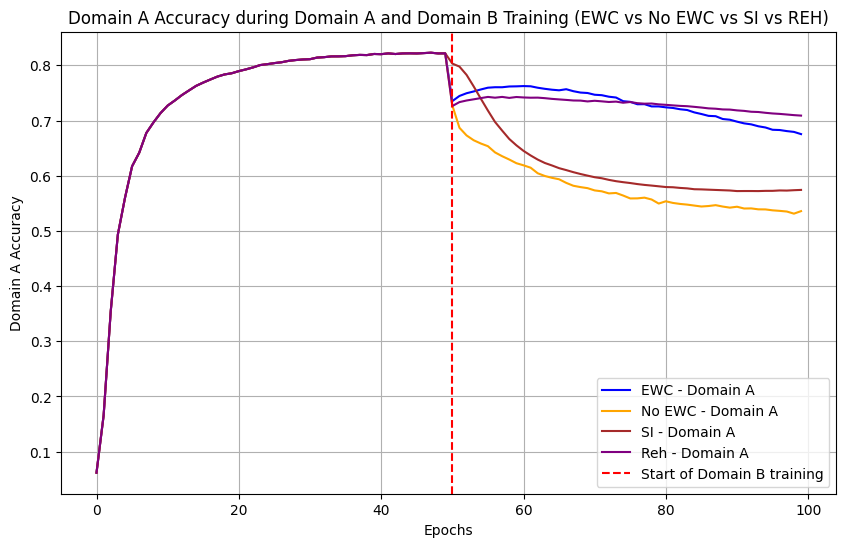

In [95]:
import matplotlib.pyplot as plt
import numpy as np
# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Same for No EWC
#pnn_A_during_A = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0) # Same for pnn
si_A_during_A = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0) # Same for si
reh_A_during_A = np.mean(epoch_stats_other_reh["reh"]["A_during_A_val"], axis=0) # Same for reh

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["A_during_B_val"], axis=0)  # Average over runs
no_ewc_task_A_during_B = np.mean(epoch_stats_correct["no_ewc"]["A_during_B_val"], axis=0)  # Same for No EWC
#pnn_task_A_during_B = np.mean(epoch_stats_other["pnn"]["val_task_A_during_B"], axis=0) # Same for pnn
si_task_A_during_B = np.mean(epoch_stats_other["si"]["val_task_A_during_B"], axis=0) # Same for si
reh_task_A_during_B = np.mean(epoch_stats_other_reh["reh"]["val_task_A_during_B"], axis=0) # Same for reh

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B])
#pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B])
si_task_A_combined = np.concatenate([ewc_initial_acc, si_task_A_during_B])
reh_task_A_combined = np.concatenate([no_ewc_initial_acc, reh_task_A_during_B])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Domain A', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Domain A', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Domain A', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Domain A', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Domain A', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Domain A Accuracy')
plt.title('Domain A Accuracy during Domain A and Domain B Training (EWC vs No EWC vs SI vs REH)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('DIL_real_world_A_during_A_and_B.png')
plt.show()


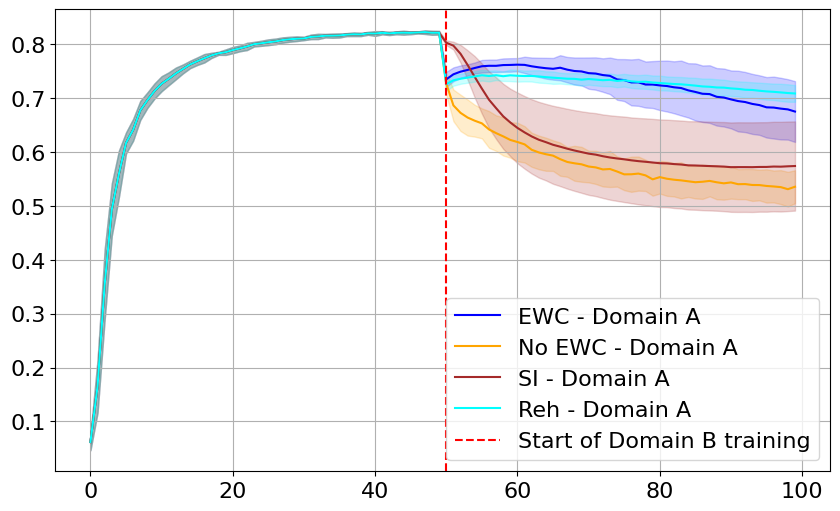

In [97]:
# Calculate standard deviations for variance bands
ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)
no_ewc_initial_acc_std = np.std(epoch_stats["ewc"]["A_during_A_val"], axis=0)
si_initial_acc_std = np.std(epoch_stats_other["si"]["A_during_A_val"], axis=0)
reh_initial_acc_std = np.std(epoch_stats_other_reh["reh"]["A_during_A_val"], axis=0)

ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["A_during_B_val"], axis=0)
no_ewc_task_A_during_B_std = np.std(epoch_stats_correct["no_ewc"]["A_during_B_val"], axis=0)
si_task_A_during_B_std = np.std(epoch_stats_other["si"]["val_task_A_during_B"], axis=0)
reh_task_A_during_B_std = np.std(epoch_stats_other_reh["reh"]["val_task_A_during_B"], axis=0)

# Combine mean and std into final arrays for plotting
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std])
si_task_A_combined_std = np.concatenate([ewc_initial_acc_std, si_task_A_during_B_std])
reh_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, reh_task_A_during_B_std])

# Plot with variance bands
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Domain A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_combined_std, ewc_task_A_combined + ewc_task_A_combined_std, color='blue', alpha=0.2)

plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Domain A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_combined_std, no_ewc_task_A_combined + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

plt.plot(x_values, si_task_A_combined, label='SI - Domain A', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_combined_std, si_task_A_combined + si_task_A_combined_std, color='brown', alpha=0.2)

plt.plot(x_values, reh_task_A_combined, label='Reh - Domain A', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_combined_std, reh_task_A_combined + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)
plt.grid(True)

# Save and show the plot
plt.savefig('DIL_real_world_A_during_A_and_B_with_variance_bigger.png')
plt.show()


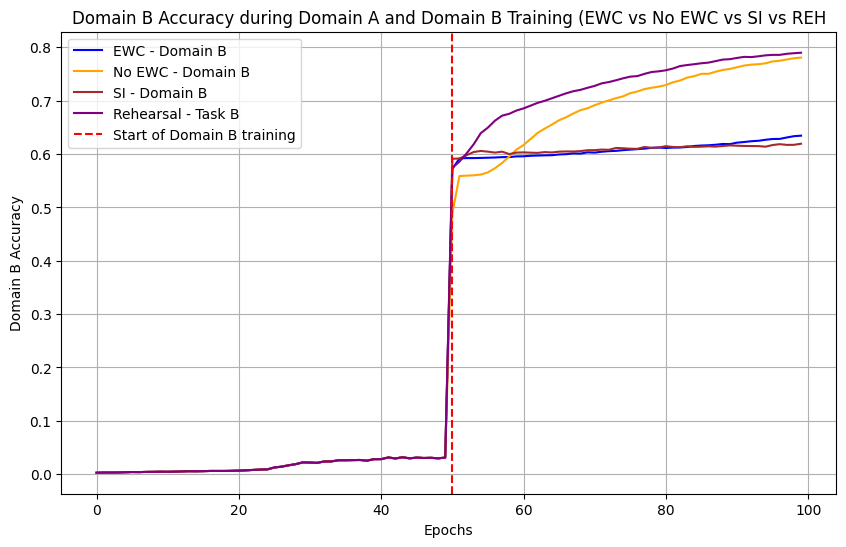

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean across runs for each method
task_B_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Mean across runs for EWC
task_B_no_ewc = np.mean(epoch_stats_correct["no_ewc"]["val_task_B"], axis=0)  # Mean across runs for No EWC
task_B_si = np.mean(epoch_stats_other["si"]["val_task_B"], axis=0)  # Mean across runs for SI
task_B_reh = np.mean(epoch_stats_other_reh["reh"]["val_task_B"], axis=0)  # Mean across runs for Rehearsal


# Compute the mean across runs for each method on Task B during training on Task A
task_B_during_A_ewc = np.mean(epoch_stats_correct["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_no_ewc = np.mean(epoch_stats_correct["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_si = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0)
task_B_during_A_reh = np.mean(epoch_stats_other_reh["reh"]["B_during_A_val"], axis=0)


# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])

si_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_si])
reh_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_reh])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for EWC, No EWC, SI, and Rehearsal
ax1.plot(x_values, ewc_task_B_combined, label='EWC - Domain B', color='blue')
ax1.plot(x_values, no_ewc_task_B_combined, label='No EWC - Domain B', color='orange')
ax1.plot(x_values, si_task_B_combined, label='SI - Domain B', color='brown')
ax1.plot(x_values, reh_task_B_combined, label='Rehearsal - Task B', color='purple')
#ax1.plot(x_values, pnn_task_B_combined, label='PNN - Domain B', color='green')
ax1.axvline(x=len(task_B_ewc), color='red', linestyle='--', label='Start of Domain B training')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Domain B Accuracy')
ax1.grid(True)
ax1.legend(loc='upper left')

#Title
plt.title('Domain B Accuracy during Domain A and Domain B Training (EWC vs No EWC vs SI vs REH')

# Show the plot
#plt.savefig('DIL_Real_World_Domain_B_During_A_and_B.png')
plt.show()


C:\Users\gslax\myenv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gslax\myenv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\gslax\myenv\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\gslax\myenv\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\gslax\myenv\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


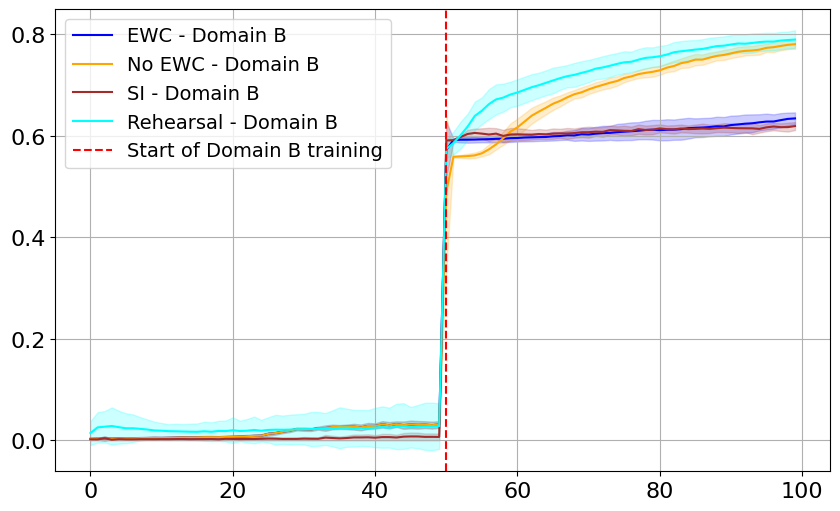

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean across runs for each method
task_B_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Mean across runs for EWC
task_B_no_ewc = np.mean(epoch_stats_correct["no_ewc"]["val_task_B"], axis=0)  # Mean across runs for No EWC
task_B_si = np.mean(epoch_stats_other["si"]["val_task_B"], axis=0)  # Mean across runs for SI
task_B_reh = np.mean(epoch_stats_other_reh["reh"]["val_task_B"], axis=0)  # Mean across runs for Rehearsal
task_B_pnn = np.mean(epoch_stats_other["pnn"]["val_task_B"], axis=0)  # Mean across runs for PNN

# Compute the standard deviation for variance bands
task_B_ewc_std = np.std(epoch_stats["ewc"]["val_task_B"], axis=0)
task_B_no_ewc_std = np.std(epoch_stats_correct["no_ewc"]["val_task_B"], axis=0)
task_B_si_std = np.std(epoch_stats_other["si"]["val_task_B"], axis=0)
task_B_reh_std = np.std(epoch_stats_other_reh["reh"]["val_task_B"], axis=0)
task_B_pnn_std = np.std(epoch_stats_other["pnn"]["val_task_B"], axis=0)

# Compute the mean and standard deviation during Task A training
task_B_during_A_ewc_std = np.std(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_no_ewc_std = np.std(epoch_stats["ewc"]["B_during_A_val"], axis=0)
task_B_during_A_si_std = np.std(epoch_stats_other["si"]["B_during_A_val"], axis=0)
task_B_during_A_reh_std = np.std(epoch_stats_other_reh["reh"]["B_during_A_val"], axis=0)
task_B_during_A_pnn_std = np.std(epoch_stats_other["pnn"]["B_during_A_val"], axis=0)

# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_B_combined = np.concatenate([task_B_during_A_ewc, task_B_ewc])
no_ewc_task_B_combined = np.concatenate([task_B_during_A_no_ewc, task_B_no_ewc])
si_task_B_combined = np.concatenate([task_B_during_A_no_ewc_std, task_B_si])
reh_task_B_combined = np.concatenate([task_B_during_A_reh, task_B_reh])

# Combine the standard deviations for both phases
ewc_task_B_combined_std = np.concatenate([task_B_during_A_ewc_std, task_B_ewc_std])
no_ewc_task_B_combined_std = np.concatenate([task_B_during_A_no_ewc_std, task_B_no_ewc_std])
si_task_B_combined_std = np.concatenate([task_B_during_A_no_ewc_std, task_B_si_std])
reh_task_B_combined_std = np.concatenate([task_B_during_A_reh_std, task_B_reh_std])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results with variance bands
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot with variance bands for EWC
ax1.plot(x_values, ewc_task_B_combined, label='EWC - Domain B', color='blue')
ax1.fill_between(x_values, ewc_task_B_combined - ewc_task_B_combined_std, ewc_task_B_combined + ewc_task_B_combined_std, color='blue', alpha=0.2)

# Plot with variance bands for No EWC
ax1.plot(x_values, no_ewc_task_B_combined, label='No EWC - Domain B', color='orange')
ax1.fill_between(x_values, no_ewc_task_B_combined - no_ewc_task_B_combined_std, no_ewc_task_B_combined + no_ewc_task_B_combined_std, color='orange', alpha=0.2)

# Plot with variance bands for SI
ax1.plot(x_values, si_task_B_combined, label='SI - Domain B', color='brown')
ax1.fill_between(x_values, si_task_B_combined - si_task_B_combined_std, si_task_B_combined + si_task_B_combined_std, color='brown', alpha=0.2)

# Plot with variance bands for Rehearsal
ax1.plot(x_values, reh_task_B_combined, label='Rehearsal - Domain B', color='cyan')
ax1.fill_between(x_values, reh_task_B_combined - reh_task_B_combined_std, reh_task_B_combined + reh_task_B_combined_std, color='cyan', alpha=0.2)

# Add vertical line to indicate transition
ax1.axvline(x=len(task_B_during_A_ewc), color='red', linestyle='--', label='Start of Domain B training')

# Add labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(loc='upper left', fontsize=14)
plt.grid(True)

# Save and show the plot
#plt.savefig('DIL_Real_World_Domain_B_During_A_and_B_with_variance_bigger.png')
plt.show()


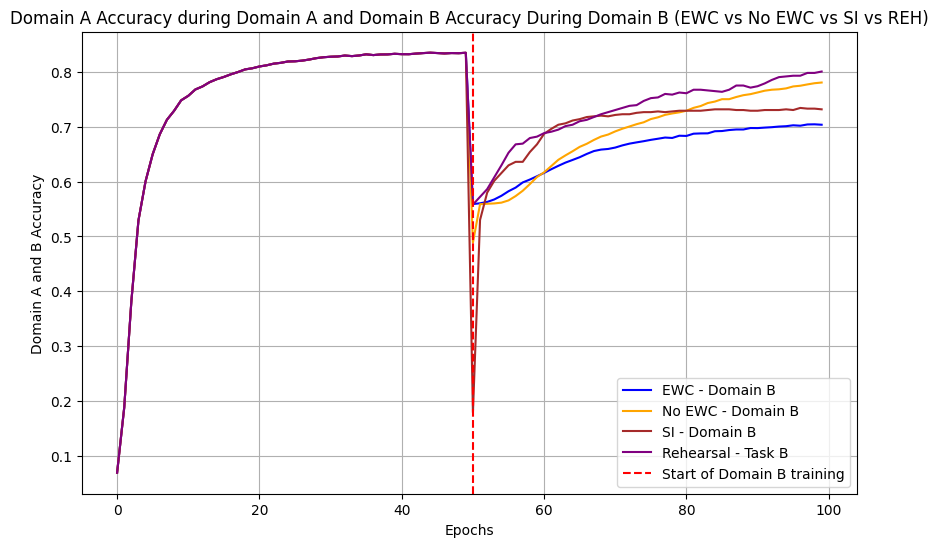

In [295]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the mean across runs for each method
task_B_ewc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs for EWC
task_B_no_ewc = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs for No EWC
task_B_si = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs for SI
task_B_reh = np.mean(epoch_stats["ewc"]["A_during_A_val"], axis=0)  # Mean across runs for Rehearsal
task_B_pnn = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0)  # Mean across runs for PNN

# Compute the mean across runs for each method on Task B during training on Task A
task_B_during_A_ewc = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)
task_B_during_A_no_ewc = np.mean(epoch_stats["no_ewc"]["val_task_B"], axis=0)
task_B_during_A_si = np.mean(epoch_stats_other["si"]["val_task_B"], axis=0)
task_B_during_A_reh = np.mean(epoch_stats_other["reh"]["val_task_B"], axis=0)
task_B_during_A_pnn = np.mean(epoch_stats_other["pnn"]["val_task_B"], axis=0)

# Concatenate Task B accuracy for both phases: during Task A and during Task B training
ewc_task_B_combined = np.concatenate([task_B_ewc, task_B_during_A_ewc])
no_ewc_task_B_combined = np.concatenate([task_B_no_ewc,task_B_during_A_no_ewc ])
pnn_task_B_combined = np.concatenate([task_B_pnn,task_B_during_A_pnn ])
si_task_B_combined = np.concatenate([task_B_si,task_B_during_A_si ])
reh_task_B_combined = np.concatenate([task_B_reh,task_B_during_A_reh ])

# Define x-axis for the entire epoch range across both phases
total_epochs = len(ewc_task_B_combined)
x_values = np.arange(total_epochs)

# Plot the results
plt.figure(figsize=(10, 6))

# Plot Acc for each method
# Plot Task B accuracy during training on Task B for each method
plt.plot(x_values, ewc_task_B_combined, label='EWC - Domain B', color='blue')
plt.plot(x_values, no_ewc_task_B_combined, label='No EWC - Domain B', color='orange')
#plt.plot(x_values, pnn_task_B_combined, label='PNN - Domain B', color='green')
plt.plot(x_values, si_task_B_combined, label='SI - Domain B', color='brown')
plt.plot(x_values, reh_task_B_combined, label='Rehearsal - Task B', color='purple')

# Mark the point where Task B training begins
plt.axvline(x=len(task_B_ewc), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Domain A and B Accuracy')
plt.title('Domain A Accuracy during Domain A and Domain B Accuracy During Domain B (EWC vs No EWC vs SI vs REH)')
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('DIL_Real_World_Domain_A_During_A_and_B_during_B.png')
plt.show()


In [55]:
epoch_stats_other["si"]["A_during_A_val"]

[]

In [100]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats_correct["ewc"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats_correct["ewc"]["A_during_A_val"])[:, -1])
#avg_final_epoch_task_A_A_si = np.mean(np.array(epoch_stats_other["si"]["A_during_A_val"])[:, -1])
#avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats_other_reh["reh"]["A_during_A_val"])[:, -1])

# Helper function to calculate final epoch stats including standard deviation
def calculate_final_epoch_stats(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    std_final = np.std(data[:, -1])  # Standard deviation of the final epoch
    upper_bound = mean_final + 2 * std_final
    lower_bound = mean_final - 2 * std_final
    return max_final, min_final, mean_final, upper_bound, lower_bound

# Extract stats for Task A during Task A training
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats_correct["ewc"]["A_during_A_val"])[:, -1])

# Extract final epoch statistics for Task A during Task B training with bounds
ewc_max_final, ewc_min_final, ewc_mean_final, ewc_upper, ewc_lower = calculate_final_epoch_stats(epoch_stats["ewc"], "A_during_B_val")
no_ewc_max_final, no_ewc_min_final, no_ewc_mean_final, no_ewc_upper, no_ewc_lower = calculate_final_epoch_stats(epoch_stats_correct["no_ewc"], "A_during_B_val")
si_max_final, si_min_final, si_mean_final, si_upper, si_lower = calculate_final_epoch_stats(epoch_stats_other["si"], "val_task_A_during_B")
reh_max_final, reh_min_final, reh_mean_final, reh_upper, reh_lower = calculate_final_epoch_stats(epoch_stats_other_reh["reh"], "val_task_A_during_B")

# Create summary table
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Domain A After A": [avg_final_epoch_task_A_A] * 4,
    "Max Acc After B": [ewc_max_final, no_ewc_max_final, si_max_final, reh_max_final],
    "Min Acc After B": [ewc_min_final, no_ewc_min_final, si_min_final, reh_min_final],
    "Mean Acc After B": [ewc_mean_final, no_ewc_mean_final, si_mean_final, reh_mean_final],
    "Upper Bound": [ewc_upper, no_ewc_upper, si_upper, reh_upper],
    "Lower Bound": [ewc_lower, no_ewc_lower, si_lower, reh_lower]
})


# Display results
# Display results using print for both tables


print("\Domain A Performance After Training on Domain A and After Domain B")
print(final_epoch_summary)





\Domain A Performance After Training on Domain A and After Domain B
      Method  Domain A After A  Max Acc After B  Min Acc After B  \
0        EWC          0.834961         0.761500         0.555556   
1     No EWC          0.834961         0.598372         0.496461   
2         SI          0.834961         0.808209         0.507785   
3  Rehearsal          0.834961         0.728946         0.680113   

   Mean Acc After B  Upper Bound  Lower Bound  
0          0.675407     0.788349     0.562465  
1          0.535810     0.597071     0.474549  
2          0.574275     0.739869     0.408680  
3          0.708953     0.739881     0.678024  


In [79]:
# Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate final epoch statistics including standard deviation
def calculate_final_epoch_stats_task_B(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    std_final = np.std(data[:, -1])  # Standard deviation of the final epoch
    upper_bound = mean_final + 2 * std_final
    lower_bound = mean_final - 2 * std_final
    return mean_final, max_final, min_final, upper_bound, lower_bound

# Calculate stats for each method
task_B_ewc_mean, task_B_ewc_max, task_B_ewc_min, task_B_ewc_upper, task_B_ewc_lower = calculate_final_epoch_stats_task_B(epoch_stats["ewc"], "val_task_B")
task_B_no_ewc_mean, task_B_no_ewc_max, task_B_no_ewc_min, task_B_no_ewc_upper, task_B_no_ewc_lower = calculate_final_epoch_stats_task_B(epoch_stats_correct["no_ewc"], "val_task_B")
task_B_si_mean, task_B_si_max, task_B_si_min, task_B_si_upper, task_B_si_lower = calculate_final_epoch_stats_task_B(epoch_stats_other["si"], "val_task_B")
task_B_reh_mean, task_B_reh_max, task_B_reh_min, task_B_reh_upper, task_B_reh_lower = calculate_final_epoch_stats_task_B(epoch_stats_other_reh["reh"], "val_task_B")

# Create a summary table for Task B during Task B training
final_epoch_task_B_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Mean Final Acc": [task_B_ewc_mean, task_B_no_ewc_mean, task_B_si_mean, task_B_reh_mean],
    "Max Final Acc": [task_B_ewc_max, task_B_no_ewc_max, task_B_si_max, task_B_reh_max],
    "Min Final Acc": [task_B_ewc_min, task_B_no_ewc_min, task_B_si_min, task_B_reh_min],
    "Upper Bound": [task_B_ewc_upper, task_B_no_ewc_upper, task_B_si_upper, task_B_reh_upper],
    "Lower Bound": [task_B_ewc_lower, task_B_no_ewc_lower, task_B_si_lower, task_B_reh_lower]
})



# Display results for Task B
print("Final Epoch Summary for Domain B During Domain B Training")
print(final_epoch_task_B_summary)


Final Epoch Summary for Domain B During Domain B Training
      Method  Mean Final Acc  Max Final Acc  Min Final Acc  Upper Bound  \
0        EWC        0.634413       0.650472       0.612686     0.658142   
1     No EWC        0.780715       0.793103       0.766284     0.795523   
2         SI        0.621772       0.639676       0.607287     0.636273   
3  Rehearsal        0.789862       0.822454       0.756463     0.826444   

   Lower Bound  
0     0.610684  
1     0.765907  
2     0.607272  
3     0.753279  


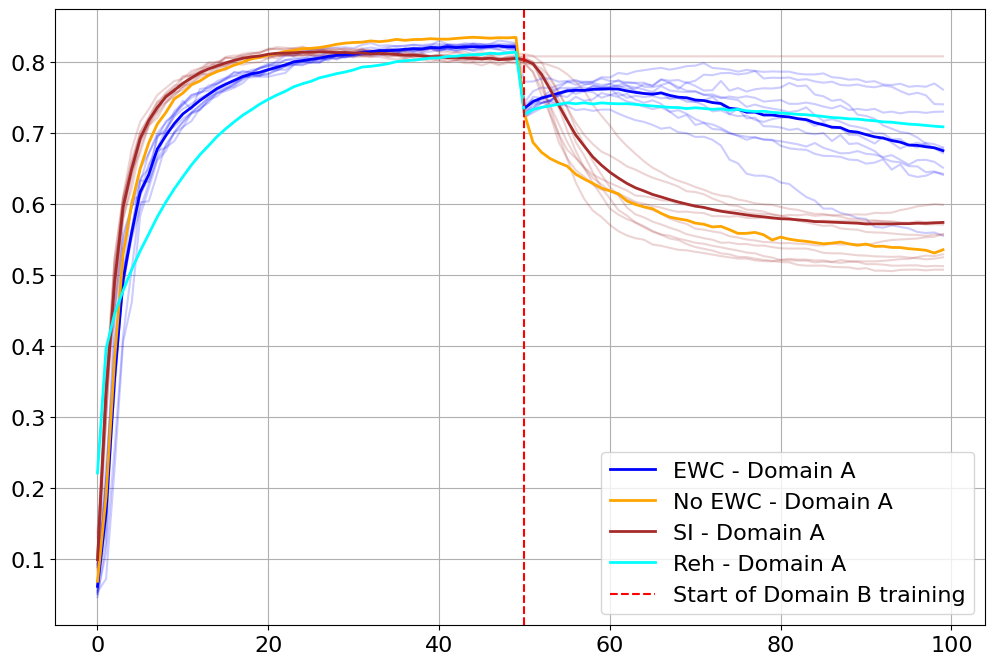

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Extract individual runs for each method
ewc_runs = np.array(epoch_stats["ewc"]["A_during_B_val"])  # Shape: (num_runs, num_epochs)
no_ewc_runs = np.array(epoch_stats_correct["no_ewc"]["A_during_B_val"])
si_runs = np.array(epoch_stats_other["si"]["val_task_A_during_B"])
reh_runs = np.array(epoch_stats_other_reh["reh"]["val_task_A_during_B"])

# Extract initial phase performance (before Task B starts)
ewc_initial = np.array(epoch_stats["ewc"]["A_during_A_val"])
no_ewc_initial = np.array(epoch_stats_correct["ewc"]["A_during_A_val"])
si_initial = np.array(epoch_stats_other["si"]["A_during_A_val"])
reh_initial = np.array(epoch_stats_other_reh["reh"]["A_during_A_val"])

# Concatenate initial phase with Task B phase for each run
ewc_full = np.concatenate([ewc_initial, ewc_runs], axis=1)  
no_ewc_full = np.concatenate([no_ewc_initial, no_ewc_runs], axis=1)
si_full = np.concatenate([si_initial, si_runs], axis=1)
reh_full = np.concatenate([reh_initial, reh_runs], axis=1)

# Define x-axis
total_epochs = ewc_full.shape[1]
x_values = np.arange(total_epochs)

plt.figure(figsize=(12, 8))

# Plot individual runs for each method
for i in range(ewc_full.shape[0]):  # Loop over 10 runs
    plt.plot(x_values, ewc_full[i], color='blue', alpha=0.2)
    #plt.plot(x_values, no_ewc_full[i], color='orange', alpha=0.2)
    plt.plot(x_values, si_full[i], color='brown', alpha=0.2)
    #plt.plot(x_values, reh_full[i], color='cyan', alpha=0.2)

# Plot mean trends for clarity
plt.plot(x_values, np.mean(ewc_full, axis=0), color='blue', label='EWC - Domain A', linewidth=2)
plt.plot(x_values, np.mean(no_ewc_full, axis=0), color='orange', label='No EWC - Domain A', linewidth=2)
plt.plot(x_values, np.mean(si_full, axis=0), color='brown', label='SI - Domain A', linewidth=2)
plt.plot(x_values, np.mean(reh_full, axis=0), color='cyan', label='Reh - Domain A', linewidth=2)

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial[0]), color='red', linestyle='--', label='Start of Domain B training')

# Formatting
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

# Save and display the plot
plt.savefig('DIL_real_world_A_during_A_and_B_individual_runs.png')
plt.show()


In [50]:
import numpy as np
import torch
import torch.nn as nn

# Define lambda variations (±1%, ±2%, ±5%, ±10%)
baseline_lambda = 50000  # Example baseline
lambda_variations = [1.01, 0.99, 1.02, 0.98, 1.05, 0.95, 1.10, 0.90]  
lambda_values = [baseline_lambda] + [int(baseline_lambda * factor) for factor in lambda_variations]

# Initialize storage for each lambda
epoch_stats_sensitivity = {f"ewc_lambda_{lam}": {"A_during_B": [], "B_during_A": [], "task_A": [], "task_B": []} for lam in lambda_values}

epochs = 50
num_runs = 10  # Each lambda value gets 10 trials
lr = 0.0001
input_dim = 2000  
hidden_dim = 256

for lambda_ewc in lambda_values:
    print(f"Running EWC with lambda_ewc = {lambda_ewc}")
    
    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}")

        # Initialize model and optimizer
        output_dim_20ng = 20  
        model = NewsNet(input_dim, hidden_dim, output_dim_20ng)
        model.expand_output(new_output_dim=len(class_A) + len(class_B))
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Initialize lists for per-epoch tracking
        task_A_ewc_run, task_B_ewc_run = [], []
        task_A_during_B_run, task_B_during_A_run = [], []

        # Train on Task A with EWC
        ewc = OnlineEWC(model, train_loader_A)

        for epoch in range(epochs):
            train_with_ewc(model, optimizer, {'train': train_loader_A, 'val': val_loader_A}, ewc=None, lambda_ewc=0, epochs=1)
            acc_A = evaluate(model, val_loader_A, criterion, class_A)[0]  
            task_A_ewc_run.append(acc_A)

        # Store Task A training results
        epoch_stats_sensitivity[f"ewc_lambda_{lambda_ewc}"]["task_A"].append(task_A_ewc_run)

        # Update EWC memory and train on Task B
        ewc.update_fisher_matrix()
        ewc.store_optimal_params()

        for epoch in range(epochs):
            train_with_ewc(model, optimizer, {'train': train_loader_B, 'val': val_loader_B}, ewc=ewc, lambda_ewc=lambda_ewc, epochs=1)
            acc_B = evaluate(model, val_loader_B, criterion, class_B)[0]  
            acc_A_during_B = evaluate(model, val_loader_A, criterion, class_A)[0]

            task_B_ewc_run.append(acc_B)
            task_A_during_B_run.append(acc_A_during_B)

        # Store Task B results
        epoch_stats_sensitivity[f"ewc_lambda_{lambda_ewc}"]["task_B"].append(task_B_ewc_run)
        epoch_stats_sensitivity[f"ewc_lambda_{lambda_ewc}"]["A_during_B"].append(task_A_during_B_run)



Running EWC with lambda_ewc = 50000
  Run 1/10
Epoch 1/1, Loss: 3.511640720736894
Epoch 1/1, Loss: 2.8361501520540178
Epoch 1/1, Loss: 2.3249372850030157
Epoch 1/1, Loss: 1.7980406021667739
Epoch 1/1, Loss: 1.4168648872768042
Epoch 1/1, Loss: 1.1505964617752278
Epoch 1/1, Loss: 0.9653277580443652
Epoch 1/1, Loss: 0.8325145943112869
Epoch 1/1, Loss: 0.7321377571212178
Epoch 1/1, Loss: 0.6549182519064112
Epoch 1/1, Loss: 0.5912992493869605
Epoch 1/1, Loss: 0.5380679505356287
Epoch 1/1, Loss: 0.49358879628683694
Epoch 1/1, Loss: 0.45584719882461694
Epoch 1/1, Loss: 0.42140377628601206
Epoch 1/1, Loss: 0.39123154043718344
Epoch 1/1, Loss: 0.36482220014994715
Epoch 1/1, Loss: 0.3391882652015432
Epoch 1/1, Loss: 0.31552984395919065
Epoch 1/1, Loss: 0.2958306886490263
Epoch 1/1, Loss: 0.27556070645698333
Epoch 1/1, Loss: 0.2570981336599689
Epoch 1/1, Loss: 0.2402928360347742
Epoch 1/1, Loss: 0.22316513086960044
Epoch 1/1, Loss: 0.20885934174674187
Epoch 1/1, Loss: 0.19420790327735443
Epoch 1/

In [112]:
import numpy as np
import torch
import torch.nn as nn

# Define lambda variations (±1%, ±2%, ±5%, ±10%)
base_lambda = 9000000000000000000  # Example baseline
epochs_list = [10,12,15,18,20,25]
#epochs_list = [10]

# Initialize storage for each lambda
epoch_stats_other_sensitivity = {f"si_epochs_{lam}": {"A_during_B": [], "B_during_A": [], "task_A": [], "task_B": []} for lam in epochs_list}

#epochs = 50
num_runs = 10  # Each lambda value gets 10 trials
lr = 0.0001
input_dim = 2000  
hidden_dim = 256

for experiment_epoch in epochs_list:
    print(f"Running EWC with lambda_si = {experiment_epoch}")
    
    for run in range(num_runs):
        print(f"  Run {run + 1}/{num_runs}")

        # Initialize model and optimizer
        output_dim_20ng = 20  
        model = NewsNet(input_dim, hidden_dim, output_dim_20ng)
        model.expand_output(new_output_dim=len(class_A) + len(class_B))
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # Initialize lists for per-epoch tracking
        task_A_si_run, task_B_si_run = [], []
        task_A_during_B_run_si, task_B_during_A_run_si = [], []

        # Train on Task A with EWC
        si = SynapticIntelligence(model, train_loader_A)

        for epoch in range(experiment_epoch):
            train_with_si(model, optimizer, {'train': train_loader_A, 'val': val_loader_A}, si=None, lambda_si=0, epochs=1)
            acc_A = evaluate(model, val_loader_A, criterion, class_A)[0]  
            task_A_si_run.append(acc_A)

        # Store Task A training results
        epoch_stats_other_sensitivity[f"si_epochs_{experiment_epoch}"]["task_A"].append(task_A_si_run)

        # Update EWC memory and train on Task B
        si.update_omega()
        si.store_optimal_params() 
        
        for epoch in range(experiment_epoch):
            train_with_si(model, optimizer, {'train': train_loader_B, 'val': val_loader_B}, si=si, lambda_si=base_lambda, epochs=1)
            acc_B = evaluate(model, val_loader_B, criterion, class_B)[0]  
            acc_A_during_B = evaluate(model, val_loader_A, criterion, class_A)[0]

            task_B_si_run.append(acc_B)
            task_A_during_B_run_si.append(acc_A_during_B)

        # Store Task B results
        epoch_stats_other_sensitivity[f"si_epochs_{experiment_epoch}"]["task_B"].append(task_B_si_run)
        epoch_stats_other_sensitivity[f"si_epochs_{experiment_epoch}"]["A_during_B"].append(task_A_during_B_run_si)



Running EWC with lambda_si = 10
  Run 1/10
Epoch 1/1, Loss: 3.5179, Penalty: 0.0000
Epoch 1/1, Loss: 2.8416, Penalty: 0.0000
Epoch 1/1, Loss: 2.3016, Penalty: 0.0000
Epoch 1/1, Loss: 1.7303, Penalty: 0.0000
Epoch 1/1, Loss: 1.3546, Penalty: 0.0000
Epoch 1/1, Loss: 1.1173, Penalty: 0.0000
Epoch 1/1, Loss: 0.9537, Penalty: 0.0000
Epoch 1/1, Loss: 0.8325, Penalty: 0.0000
Epoch 1/1, Loss: 0.7361, Penalty: 0.0000
Epoch 1/1, Loss: 0.6599, Penalty: 0.0000
Epoch 1/1, Loss: 8746170.0336, Penalty: 0.0000
Epoch 1/1, Loss: 9.7816, Penalty: 0.0000
Epoch 1/1, Loss: 8.8367, Penalty: 0.0000
Epoch 1/1, Loss: 8.1978, Penalty: 0.0000
Epoch 1/1, Loss: 7.6846, Penalty: 0.0000
Epoch 1/1, Loss: 7.2582, Penalty: 0.0000
Epoch 1/1, Loss: 6.9038, Penalty: 0.0000
Epoch 1/1, Loss: 6.5748, Penalty: 0.0000
Epoch 1/1, Loss: 6.2531, Penalty: 0.0000
Epoch 1/1, Loss: 5.9370, Penalty: 0.0000
  Run 2/10
Epoch 1/1, Loss: 3.5160, Penalty: 0.0000
Epoch 1/1, Loss: 2.8190, Penalty: 0.0000
Epoch 1/1, Loss: 2.3318, Penalty: 0.00

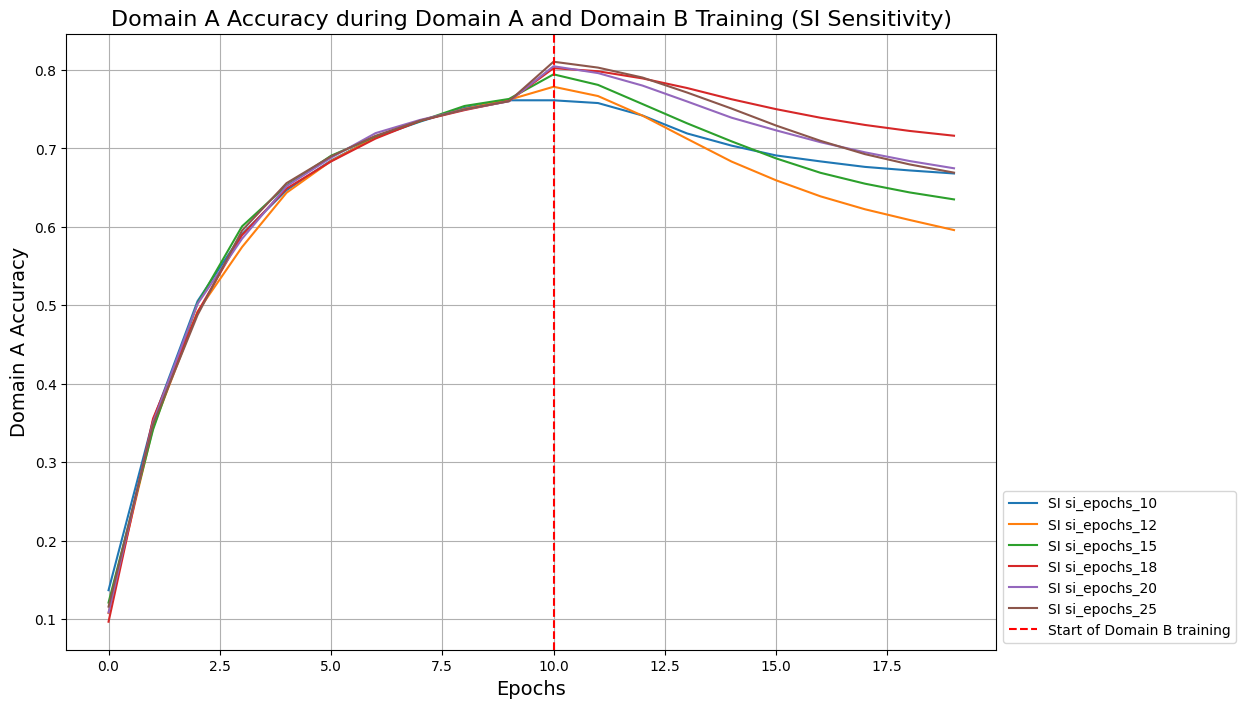

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Extract lambda values (epoch configurations)
epochs_list = list(epoch_stats_other_sensitivity.keys())

plt.figure(figsize=(12, 8))

# Plot each lambda experiment
for idx, epoch_key in enumerate(epochs_list):
    # Compute means across multiple runs (axis=0 means across runs)
    task_A_means = np.mean(epoch_stats_other_sensitivity[epoch_key]["task_A"], axis=0)[:10]  # First 10 epochs of A training
    task_A_during_B_means = np.mean(epoch_stats_other_sensitivity[epoch_key]["A_during_B"], axis=0)[:10]  # First 10 epochs of A during B training

    # Concatenate results for a smooth transition
    task_A_combined = np.concatenate([task_A_means, task_A_during_B_means])

    # Define x-axis values (10 epochs of A training + 10 epochs of A during B)
    x_values = np.arange(len(task_A_combined))

    plt.plot(x_values, task_A_combined, label=f'SI {epoch_key}')

# Mark the point where Task B training begins (after 10 epochs)
plt.axvline(x=10, color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Domain A Accuracy', fontsize=14)
plt.title('Domain A Accuracy during Domain A and Domain B Training (SI Sensitivity)', fontsize=16)
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(1, 0))
plt.grid(True)

# Display the plot
plt.show()


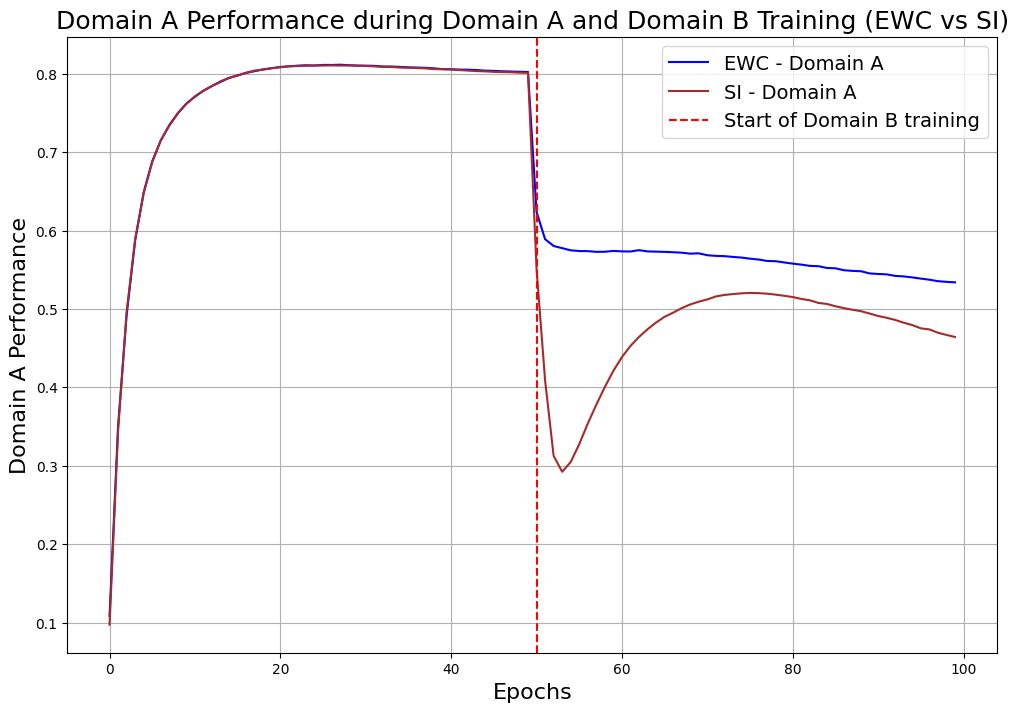

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mean performance across all lambda values for EWC in epoch_stats_sensitivity
ewc_initial_means = np.mean([np.mean(epoch_stats_sensitivity[lambda_val]["task_A"], axis=0) for lambda_val in epoch_stats_sensitivity], axis=0)
ewc_task_A_during_B_means = np.mean([np.mean(epoch_stats_sensitivity[lambda_val]["A_during_B"], axis=0) for lambda_val in epoch_stats_sensitivity], axis=0)

# Extract mean performance across all lambda values for SI in epoch_stats_other_sensitivity
si_initial_means = np.mean([np.mean(epoch_stats_other_sensitivity[lambda_val]["task_A"], axis=0) for lambda_val in epoch_stats_other_sensitivity], axis=0)
si_task_A_during_B_means = np.mean([np.mean(epoch_stats_other_sensitivity[lambda_val]["A_during_B"], axis=0) for lambda_val in epoch_stats_other_sensitivity], axis=0)

# Concatenate Task A training and A_during_B for full trajectory
ewc_task_A_combined = np.concatenate([ewc_initial_means, ewc_task_A_during_B_means])
si_task_A_combined = np.concatenate([si_initial_means, si_task_A_during_B_means])

# Define x-axis values
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(12, 8))

# Plot EWC mean performance
plt.plot(x_values, ewc_task_A_combined, label='EWC - Domain A', color='blue')

# Plot SI mean performance
plt.plot(x_values, si_task_A_combined, label='SI - Domain A', color='brown')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_means), color='red', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Domain A Performance', fontsize=16)
plt.title('Domain A Performance during Domain A and Domain B Training (EWC vs SI)', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)

# Display the plot
plt.show()


In [75]:
print(len(epoch_stats_sensitivity))
print(len(epoch_stats_other_sensitivity))

9
9


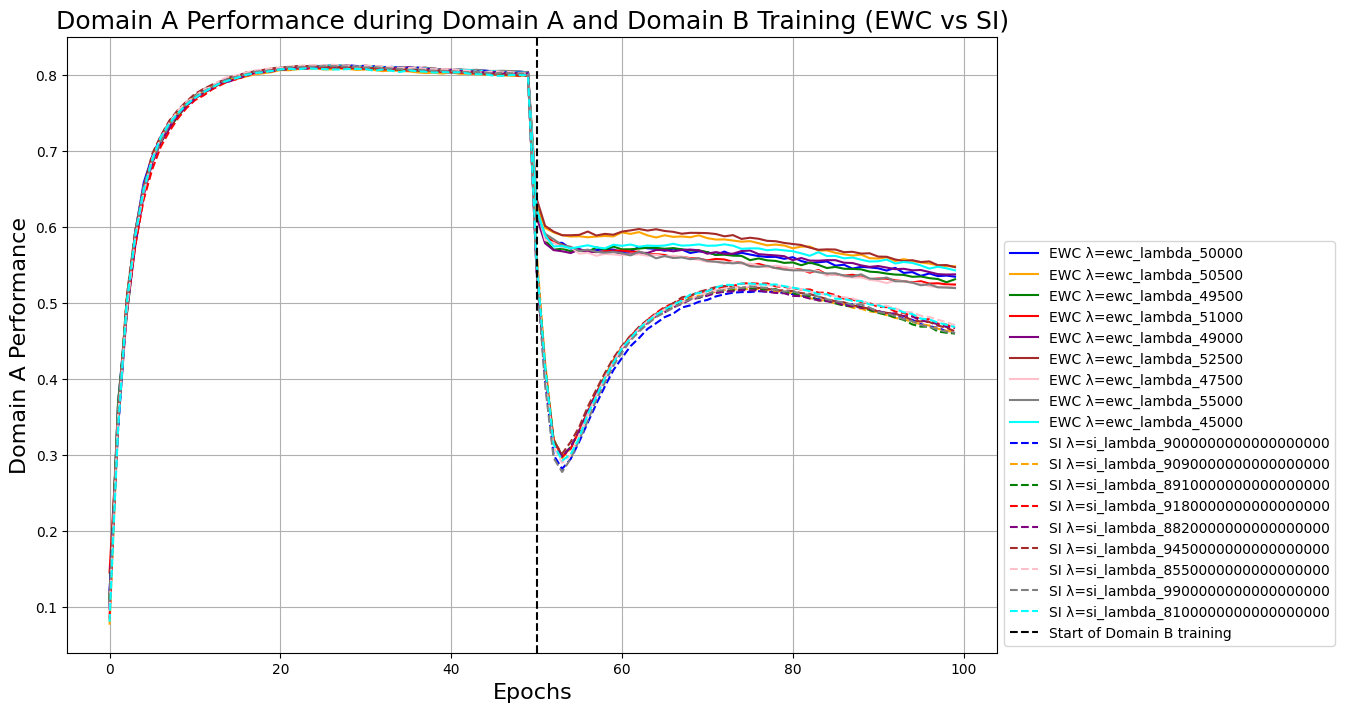

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for different lambda values
colors = [
    "blue", "orange", "green", "red", "purple", "brown", "pink", "gray","cyan"
]

# Extract lambda values
lambda_values_ewc = list(epoch_stats_sensitivity.keys())
lambda_values_si = list(epoch_stats_other_sensitivity.keys())

# Define x-axis values (assuming all runs have the same number of epochs)
total_epochs_ewc = len(epoch_stats_sensitivity[lambda_values_ewc[0]]["task_A"][0]) + \
                   len(epoch_stats_sensitivity[lambda_values_ewc[0]]["A_during_B"][0])
total_epochs_si = len(epoch_stats_other_sensitivity[lambda_values_si[0]]["task_A"][0]) + \
                  len(epoch_stats_other_sensitivity[lambda_values_si[0]]["A_during_B"][0])

x_values_ewc = np.arange(total_epochs_ewc)
x_values_si = np.arange(total_epochs_si)

plt.figure(figsize=(12, 8))

# Plot each lambda experiment for EWC
for idx, lambda_val in enumerate(lambda_values_ewc):
    ewc_initial_means = np.mean(epoch_stats_sensitivity[lambda_val]["task_A"], axis=0)
    ewc_task_A_during_B_means = np.mean(epoch_stats_sensitivity[lambda_val]["A_during_B"], axis=0)
    ewc_task_A_combined = np.concatenate([ewc_initial_means, ewc_task_A_during_B_means])

    plt.plot(x_values_ewc, ewc_task_A_combined, label=f'EWC λ={lambda_val}', color=colors[idx])

# Plot each lambda experiment for SI
for idx, lambda_val in enumerate(lambda_values_si):
    si_initial_means = np.mean(epoch_stats_other_sensitivity[lambda_val]["task_A"], axis=0)
    si_task_A_during_B_means = np.mean(epoch_stats_other_sensitivity[lambda_val]["A_during_B"], axis=0)
    si_task_A_combined = np.concatenate([si_initial_means, si_task_A_during_B_means])

    plt.plot(x_values_si, si_task_A_combined, label=f'SI λ={lambda_val}', color=colors[idx], linestyle="dashed")

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_means), color='black', linestyle='--', label='Start of Domain B training')

# Labels, title, and legend
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Domain A Performance', fontsize=16)
plt.title('Domain A Performance during Domain A and Domain B Training (EWC vs SI)', fontsize=18)
plt.legend(fontsize=10, loc='lower left', bbox_to_anchor=(1, 0))
plt.grid(True)

# Display the plot
plt.show()
